# Advertising recommendation system 

Usually, a recommendation system is used by corporations in order to suggest something to their users. This "something" is usually valuable in money so suggesting an item that could be interesting for the user is positive both for the company and for the user.

# Why "advertising"?

Advertising the right customers about a product could make the difference. 
The idea behind this project is to give to the company a suggestion on which users, who are really interested in the product, to advertise. Doing this, we will avoid to spam ads which are not interesting for the user.

<img src="Images/ads.jpg" />

# Building a recommendation system

We are going to try to build this kind of recommendation system with only a small amount of data crawled from reddit.
In particular, we are going to get some data from r/movies.

# What do we need to build a recommendation system?

The main answer is **DATA!**

In particular, we need data about users. Indeed, in order to build a recommendation system, we need people's opinions about items. So, in our case, what we need to do is to look for discussions in which users are asked to say something about a film.

# Take a look at our data

After we've collected our data using PRAW API, let's give it a look.

In [4]:
#visualize some rows of the dataframe

,Title,Comment,User
0,What do you think about the movie The Princess...,"It never fails to bring laughs, no matter how ...",vicky436
1,What do you think about the movie The Princess...,"It's not a good movie, it's the best movie eve...",jakethesnake741
2,What do you think about the movie The Princess...,If your friend doesn't love this movie he does...,jrobertson50
3,What do you think about the movie The Princess...,Not liking the movie is inconceivable!,Antelino
4,What do you think about the movie The Princess...,#Anybody want a peanut?,UHeardAboutPluto
...,...,...,...
496,What do you think about Del Toro's CRONOS ?,"Great story and acting, and very moody",DrScientist812
497,"What do you think about Matt Reeves remake, Le...",It might be alright. I haven't seen it yet. It...,None
498,"What do you think about Matt Reeves remake, Le...",I'm *trying* not to think of it. It makes me m...,None
499,So what do you think about Nolan directing a b...,I'll allow it.*\n\n*as long as Bale/DiCaprio/J...,SithLard


In [1]:
#get some info about dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 3 columns):
Title      455 non-null object
Comment    455 non-null object
User       455 non-null object
dtypes: object(3)
memory usage: 10.8+ KB


,Title,Comment,User
count,455,455,455
unique,34,452,388
top,The Princess Bride,[deleted],None
freq,56,3,45


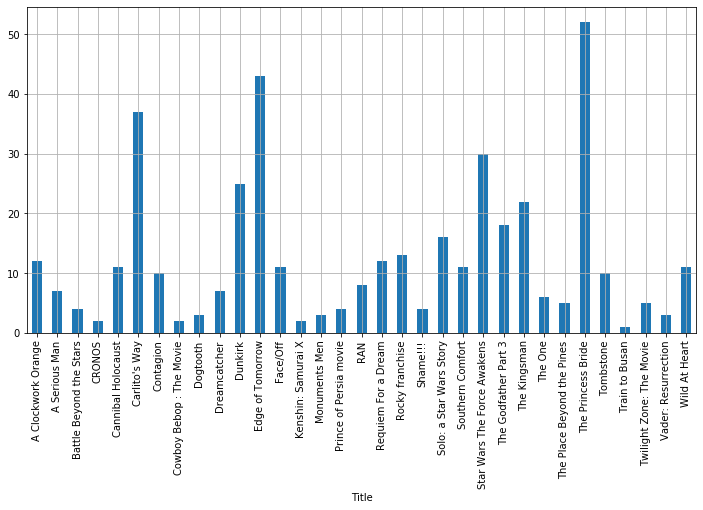

In [5]:
#plot the number of users per each discussion

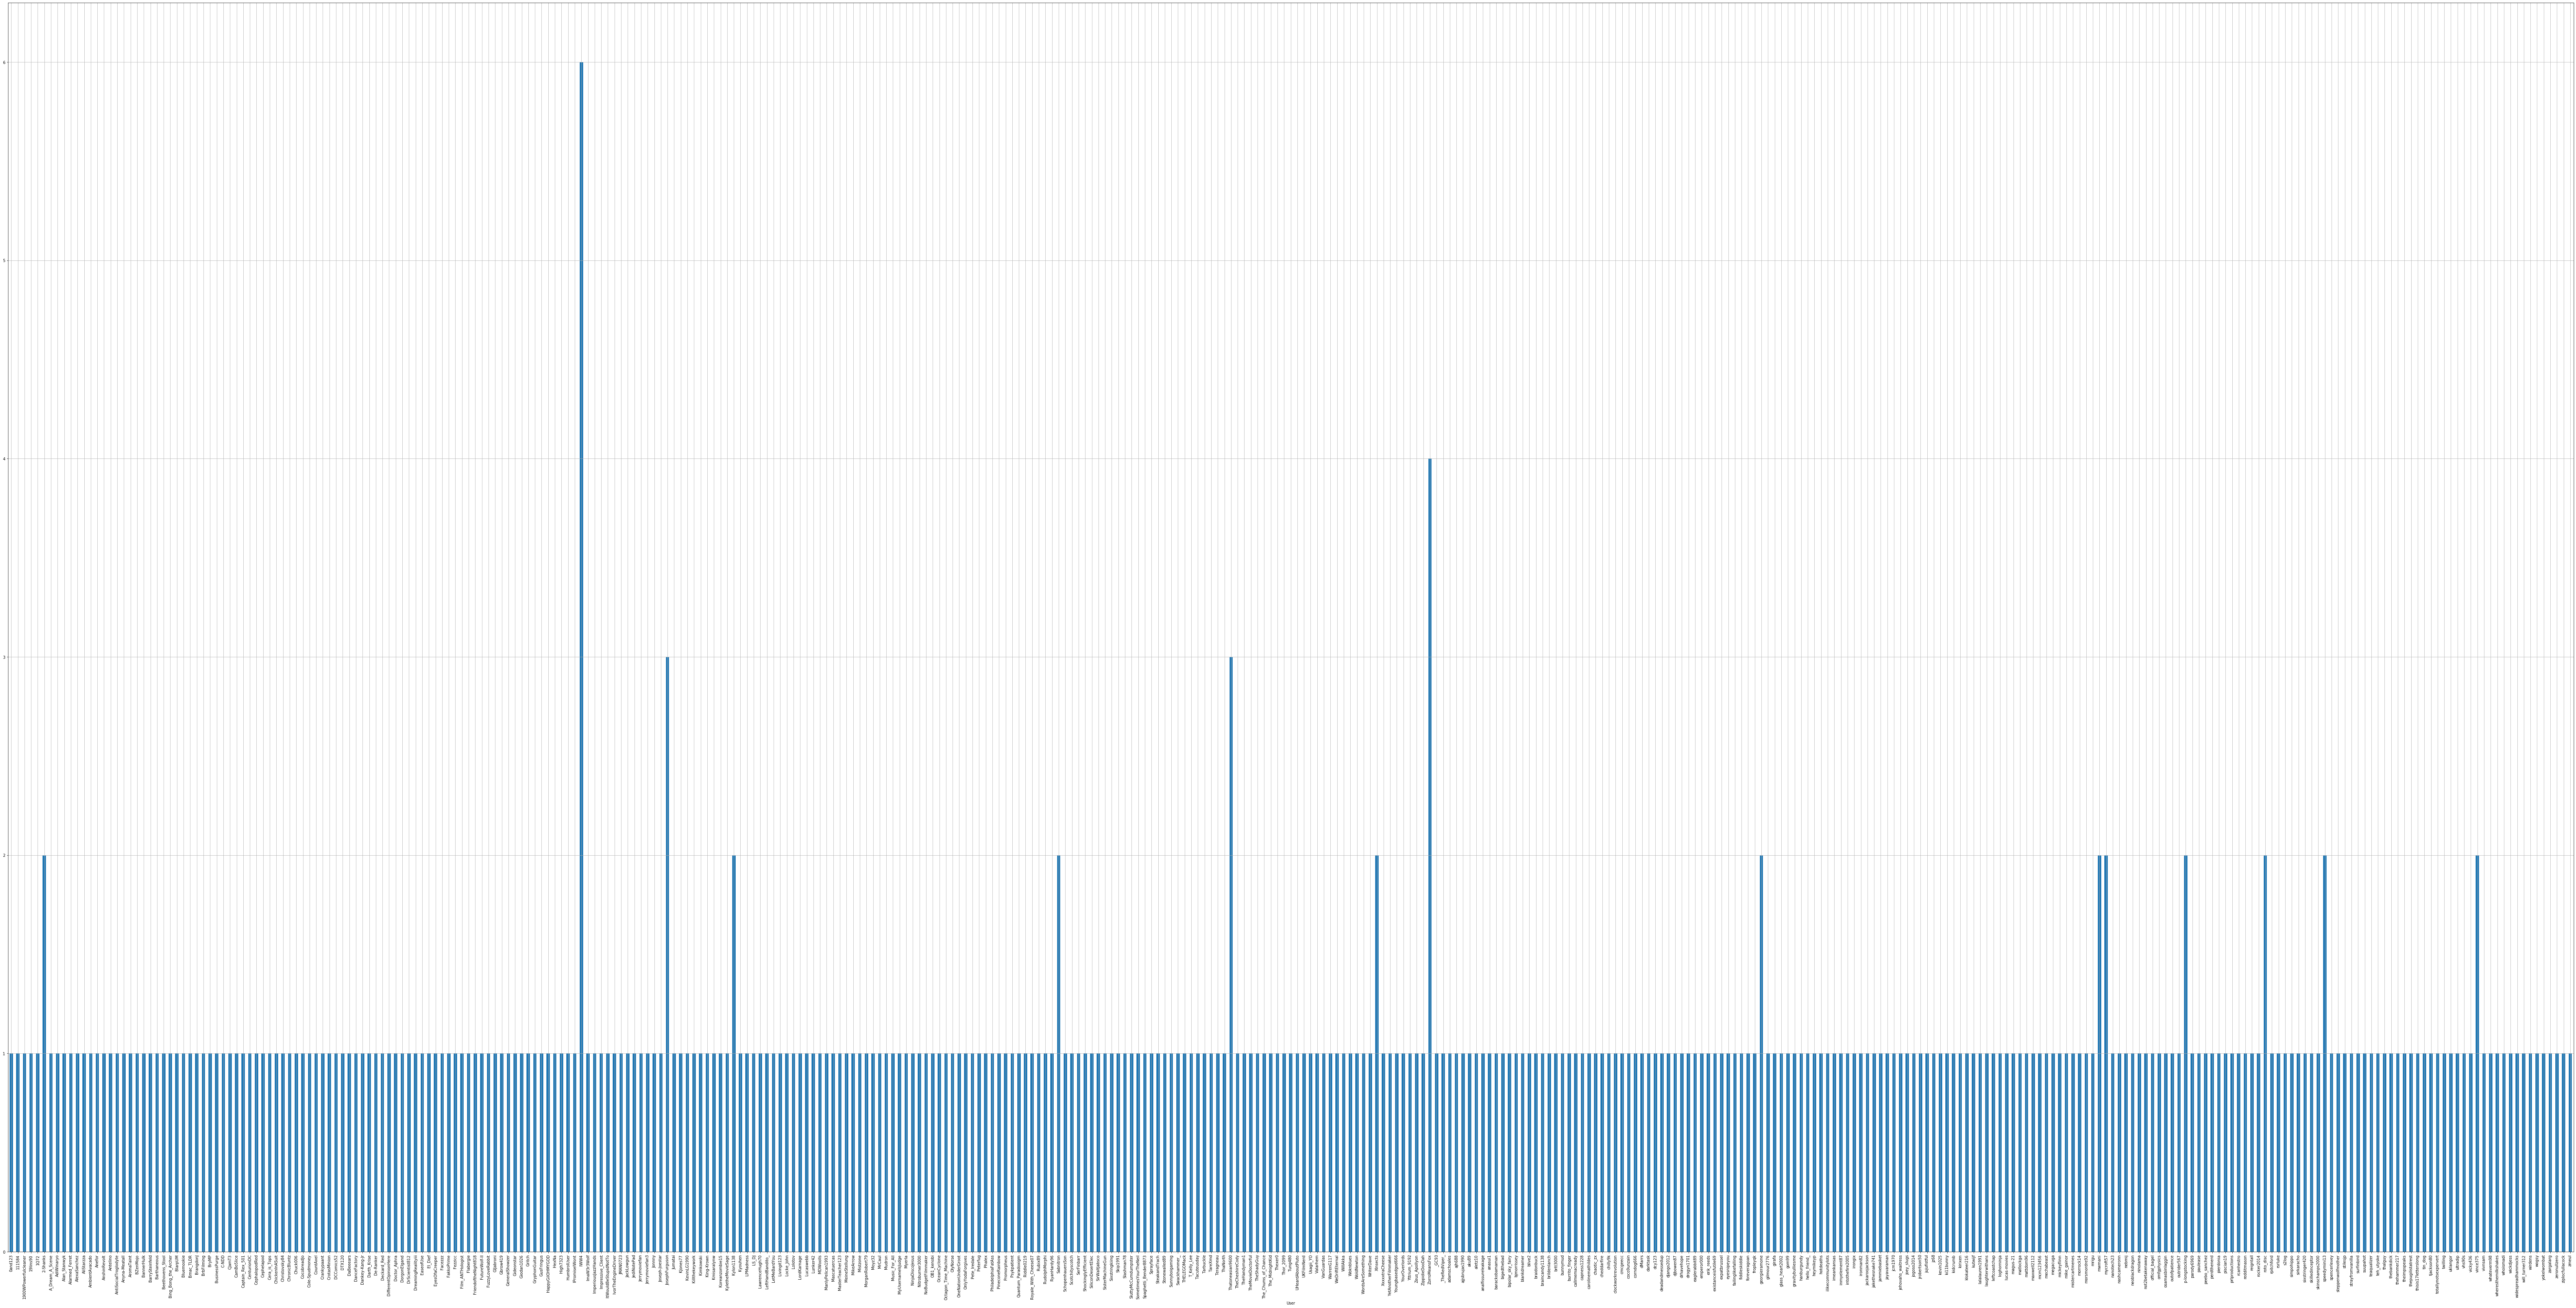

In [4]:
#plot the number of comments per user

# Transform the comments in a rating

Since we have just text comments, we need a way to transform those in a number which can express the user's opinion about that item.

# Convert comments into ratings using Sentiment Analysis
After we have collected our data  from reddit, we can start to analyze the comments in order to get the relative sentiment. In order to do this, we are going to use VADER.

In [1]:
import pandas as pd
import nltk

nltk.download('vader_lexicon')

data_set = pd.read_csv('data_set.csv')
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 3 columns):
Title      455 non-null object
Comment    455 non-null object
User       455 non-null object
dtypes: object(3)
memory usage: 10.8+ KB


# VADER
We are now going to apply VADER's algorithm to each of our comments in the dataset, taking just the compound score which is a normalized sum of all the other scores (pos, neu, neg).

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

#creating a lambda function which computes the scores for x and getting only the compound
sentiment = lambda x: sid.polarity_scores(x)['compound']
sentiment(data_set.loc[0]['Comment'])

0.5994

In [3]:
from tqdm import tqdm
tqdm.pandas()

#applying that function to our dataset
data_set['Sentiment'] = data_set['Comment'].progress_apply(sentiment)
data_set.head()

data_set.to_csv('Sentiment.csv', index=False)

/home/default/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 455/455 [00:00<00:00, 1621.74it/s]


,Title,Comment,User,Sentiment
0,A Clockwork Orange,"Loved the book, movie was mediocre",19lins90,0.5994
1,A Clockwork Orange,My buddy told me it was one of his all time fa...,Anefor,0.6369
2,A Clockwork Orange,I think it's hard to put the extreme emotions ...,cheddarfire,-0.4310
3,A Clockwork Orange,I haven't seen it but I'm tempted to watch it....,DanceFactory,-0.5965
4,A Clockwork Orange,"I saw it once, and really enjoyed it but I've ...",High7323,0.1770


# Let's now build our recommendation system

First of all, let's load our new dataset created before

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('Sentiment.csv')
data = data[data.User != "None"].reset_index(drop=True)
data = data.drop([329, 197, 112]).reset_index(drop=True).sort_values(by=['User']) #drop users who have commented the same post more than once
data.head()

,Title,Comment,User,Sentiment
119,Edge of Tomorrow,"Fantastic movie, I watched it for Emily Blunt ...",0and123,0.9201
177,Monuments Men,"It looks very good, but I am concerned about t...",111584,-0.3514
162,Face/Off,"I think you need to take it for what it is, it...",1900WPowerfulcleaner,0.8898
0,A Clockwork Orange,"Loved the book, movie was mediocre",19lins90,0.5994
326,The Princess Bride,"I broke up with a girl over this movie, after ...",1Q72,0.1154


# Transform titles and users into ids

In [2]:
#get user unique ids
users = data['User'].unique()
print(len(users))
users_id = {}

for i in range(0, len(users)):
    users_id.update({i:users[i]})
    
#assignign each comment author his id

u_id = []
for u in data['User']:
    for i in range(0,len(users_id)):
        if u == users_id[i]:
            u_id.append(i)
            
data['User_id'] = u_id

387


In [3]:
#get title unique ids

titles = data['Title'].unique() #makes an array of titles
titles_id = {}

for i in range(0, len(titles)):
    titles_id.update({i:titles[i]})

titles_id[0]

#assignign each comment author his id

t_id = []
for t in data['Title']:
    for i in range(0,len(titles_id)):
        if t == titles_id[i]:
            t_id.append(i)
            

data['Title_id'] = t_id
data

,Title,Comment,User,Sentiment,User_id,Title_id
119,Edge of Tomorrow,"Fantastic movie, I watched it for Emily Blunt ...",0and123,0.9201,0,0
177,Monuments Men,"It looks very good, but I am concerned about t...",111584,-0.3514,1,1
162,Face/Off,"I think you need to take it for what it is, it...",1900WPowerfulcleaner,0.8898,2,2
0,A Clockwork Orange,"Loved the book, movie was mediocre",19lins90,0.5994,3,3
326,The Princess Bride,"I broke up with a girl over this movie, after ...",1Q72,0.1154,4,4
...,...,...,...,...,...,...
292,The Godfather Part 3,> Robert Duvall was also sorely missed as Tom ...,yokelwombat,-0.2960,382,7
80,Contagion,Terrifying and realistic. I assembled a small ...,zargalarg,-0.7430,383,16
395,Vader: Resurrection,"I think it's a bad idea. That being said, I a...",zeronullzero,-0.6459,384,8
70,Carlito's Way,Benny from the Bronx!!,ziplocfullacock,0.0000,385,5


# Getting items profile

In order to get the item profiles we are going to create a BOW representation of all the comments, applying TF-IDF and represent each item with its representation vector.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vec = CountVectorizer()
comment_count = count_vec.fit_transform(data['Comment']) # Creating a BOW for all the comments


tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(comment_count) # Applying TF-IDF to our BOW model

item_profiles = [] # Array where profiles will be stored

for t in titles:
    data1 = data[data['Title'] == t]
    comments = [' '.join(data1['Comment'])]# Joins all the comments for that title, creating a document
    item_profiles.append(tfidf.transform(count_vec.transform(comments))) # Append the BOW representation for that title
    
print(item_profiles[0].toarray())
print(len(count_vec.vocabulary_))
item_profiles[0].shape

[[0. 0. 0. ... 0. 0. 0.]]
3096


(1, 3096)

# Calculating users profile

Since we have got so few data about users (as we can see before in the plots,the majority of the users have just expressed one opinion for one item), we are not able to use a collaborative filtering approach. Instead, we are going to use a content-based filtering approach.

We are going to calculate the user profile as the sum of each item he has "rated" multiplied by the relative sentiment.<br>
For example: the user **A** has rated these items **{1,2,3}**. The user profile is calculated as:
       <div align="center">***(profile(1) * sentiment(1)) + (profile(2) * sentiment(2)) + (profile(3) * sentiment(3))***</div>
Then, to have a normalized result, we are going to divide by the number of items he has rated.

# Code

In [5]:
# Calculate user profiles as follow:
# Sum all the item profiles for the films he gave a rating and multiply each of that for the corresponding sentiment

user_profile = []

# Getting the number of 'ratings' of users
rating_count = data.groupby(['User_id'], as_index=True).size().tolist()

for i in range (0,len(users)):
    user_profile.append(0)

# We are using this indexing so that we take the user's id from the df and insert in his corresponing item
for index, row in data.iterrows():
    user_profile[row['User_id']] += (item_profiles[row['Title_id']] * row['Sentiment'])
    
# Normalize dividing by rating_count 
for i in range(0, len(users)):
    user_profile[i] = user_profile[i] / rating_count[i]
      

print(user_profile[0].shape)
print(user_profile[26].toarray())

(1, 3096)
[[0. 0. 0. ... 0. 0. 0.]]


# System's predictions

We are going to estimate the likelihood of a user appreciating an item he doesn't know just calculating the cosine similarity between the user profile and the item profile. 
This will give us a number cromprised between -1 and 1, just as the sentiment value.<br>
Example:

In [6]:
#we are going to use the cosine function given by scipy library
from scipy import spatial

cd = 1 - spatial.distance.cosine(user_profile[0].toarray(), item_profiles[4].toarray())
cd

0.5655293825994097

# Take a look at our utility matrix

In [7]:
#creating our utility matrix
um = data.pivot_table(index='User_id', columns='Title_id', values='Sentiment')
um.head()

Title_id,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
User_id,,,,,,,,,,,,,,,,,,,,,
0,0.9201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-0.3514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.8898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.5994,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.1154,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Let's fill our utility matrix!

In [9]:
#cosine similarity function
def distance(user, item):
        distance = 1 - spatial.distance.cosine(user_profile[user].toarray(), item_profiles[item].toarray())
        return distance

In [10]:
import math

# If the cell is NaN assign the cosine similarity between the user and the item
for i in range(0, len(um)):
    for j in range(0, len(titles)):
        if(math.isnan(um.loc[i].loc[j])):
            um.loc[i].loc[j] = distance(i, j)
um.head()

/home/guberlo/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Title_id,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
User_id,,,,,,,,,,,,,,,,,,,,,
0,0.920100,0.264297,0.405923,0.530165,0.565529,0.539595,0.633302,0.560444,0.263590,0.255004,...,0.475519,0.645990,0.438511,0.452891,0.276400,0.372341,0.147490,0.414976,0.295669,0.450721
1,-0.264297,-0.351400,-0.165739,-0.246815,-0.243521,-0.212430,-0.279310,-0.254312,-0.131595,-0.087097,...,-0.222835,-0.285987,-0.234145,-0.205697,-0.100496,-0.172086,-0.063608,-0.181716,-0.108032,-0.199937
2,0.405923,0.165739,0.889800,0.367737,0.363838,0.338167,0.433341,0.359843,0.188811,0.136026,...,0.297574,0.412085,0.305322,0.318770,0.189797,0.281210,0.086764,0.274335,0.198783,0.300625
3,0.530165,0.246815,0.367737,0.599400,0.527194,0.472289,0.553433,0.507134,0.267033,0.199985,...,0.440031,0.577638,0.381888,0.417884,0.226031,0.329573,0.166558,0.387571,0.263145,0.417824
4,0.565529,0.243521,0.363838,0.527194,0.115400,0.539595,0.620647,0.559877,0.249857,0.206270,...,0.472118,0.636604,0.453969,0.508829,0.242414,0.331051,0.174369,0.432270,0.300916,0.477904


# Test if our algorithm is working or not

We have created our recommendation system but... will it work? In order to test it, we have to compare the predicted ratings with the known ratings for the users who gave more than one opinions. Let's take a look at those users:

In [11]:
# Some data about users who wrote more than one comment
d_u = data['User'] 
duplicated = data[d_u.isin(d_u[d_u.duplicated()])].sort_values("User")

duplicated.head()

,Title,Comment,User,Sentiment,User_id,Title_id
138,Edge of Tomorrow,It was great until Cruise and Blunt got to the...,IWW4,0.6249,86,0
222,Solo: a Star Wars Story,I have always found origin stories to be a was...,IWW4,-0.6486,86,14
26,Cannibal Holocaust,> Cannibal Holocaust\n\n\nI really try not to.,IWW4,0.0000,86,23
400,Wild At Heart,I don't really like it all.,IWW4,-0.3241,86,20
100,Dunkirk,I liked it less and less the more times I saw it.,IWW4,0.4215,86,24


In [12]:
# Getting the id for users who wrote more than one comment 
d_users = duplicated['User_id'].unique()
d_users

array([ 86,  99, 109, 158, 184, 206, 214, 264, 315, 328, 340, 372])

# How to test?

Since we have so few data, we are going to use the Leave-one-out method in order to test. <br> We are going to calculate each score known, one at a time, for the users who reviewed more than one item.

This is what we are going to do:
* Take a user
* Set one of his ratings to NaN
* Calculate his user profile
* Predict the ratings using cosine similarity
* Compare the predicted value with the ground truth value stored in the dataframe

This pipeline will be applied for each user who wrote more than one comment and for each item he gave an opinion

# Code

In [13]:
#in order to set each time only one value to null, we save user id as index and titles id for which he wrote a comment 
#as values so that we can choose which one to give null value 

dic = {}
arr = []

for u in d_users:
    arr = []
    for i, row in duplicated[duplicated['User_id'] == u].iterrows():
        arr.append(row['Title_id'])
        dic.update({u:arr})

dic

{86: [0, 14, 23, 20, 24, 17],
 99: [28, 25, 19],
 109: [14, 24],
 158: [17, 0],
 184: [24, 23, 4],
 206: [5, 24],
 214: [17, 31, 28, 18],
 264: [2, 22],
 315: [20, 25],
 328: [10, 28],
 340: [24, 4],
 372: [18, 21]}

# Filling the desidered cells

In [14]:

true_values = []
predicted_values = []


for i in dic: #get user id from duplicated users
    for j in dic[i]: #get one of the item_id
        user_profile[i] = 0 #reset the user's profile each time we set a new value to NaN
        t_v = umt.iloc[i][j]
        true_values.append(t_v) #store the truth value before deleting it
        umt.iloc[i][j] = float('NaN')
        count = 0
        for l in titles_id:
            if(not math.isnan(umt.iloc[i][l])): #building new user profile not considering the new nan
                user_profile[i] += (item_profiles[l] * umt.iloc[i][l])
                count = count + 1
        user_profile[i] = user_profile[i] / count
        
        #print('User: {}, Item: {}'.format(i, j)) #debugging to see if we are calculating the right distances
        
        predicted_values.append(distance(i, j)) #store the predicted value which we have set before the value to nan
        umt.iloc[i][j] = t_v #restore the original value

# Compare the values

In [17]:
for i in range(0, len(true_values)):
     print("Predicted score: {:.3f} ----- True score: {:.3f}".format(predicted_values[i], true_values[i]))

Predicted score: -0.356 ----- True score: 0.625
Predicted score: 0.368 ----- True score: -0.649
Predicted score: 0.098 ----- True score: 0.000
Predicted score: 0.197 ----- True score: -0.324
Predicted score: -0.280 ----- True score: 0.421
Predicted score: 0.151 ----- True score: -0.340
Predicted score: -0.338 ----- True score: 0.713
Predicted score: 0.230 ----- True score: -0.202
Predicted score: 0.174 ----- True score: -0.235
Predicted score: -0.527 ----- True score: 0.153
Predicted score: 0.527 ----- True score: -0.649
Predicted score: 0.371 ----- True score: 0.586
Predicted score: 0.371 ----- True score: 0.840
Predicted score: 0.518 ----- True score: 0.892
Predicted score: 0.518 ----- True score: 0.815
Predicted score: 0.640 ----- True score: 0.000
Predicted score: 0.587 ----- True score: 0.206
Predicted score: 0.587 ----- True score: 0.782
Predicted score: 0.352 ----- True score: -0.802
Predicted score: 0.122 ----- True score: 0.874
Predicted score: 0.169 ----- True score: 0.493
Pr

# MAE

Let's now calculate the Mean Absolute Error between our predictions and the truth value

In [18]:
#measure performance with mae
def mae(y_true, y_pred):
    return (y_true-y_pred).abs().mean()

mae(pd.Series(true_values), pd.Series(predicted_values))

0.5747905734199232

# Plot to have a better understanding

Text(0, 0.5, 'Ratings')

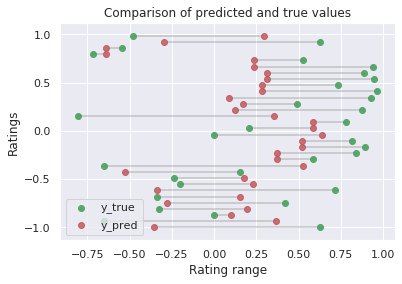

In [19]:
import matplotlib.pyplot as plt

rating_range = np.arange(-1, 1, 0.064)

plt.hlines(y=rating_range, xmin=validation['y_true'], xmax=validation['y_pred'], color='grey', alpha=0.4)
plt.scatter(validation['y_true'], rating_range, color='g', alpha=1, label='y_true')
plt.scatter(validation['y_pred'], rating_range, color='r', alpha=0.8 , label='y_pred')
plt.legend(loc='lower left')

# Add title and axis names
plt.title("Comparison of predicted and true values", loc='center')
plt.xlabel('Rating range')
plt.ylabel('Ratings')

# Does it work?

Actually, this is not the best result we'd like to get. The MAE score is too high to have a good reliability.
What we can do now is checking whether our algorithm is better than calculating the ratings randomly or not.

So instead of calculating the rating as the cosine similarity between user and item profile, we are going to calculate it as a random number between -1 and 1

In [8]:
# Random number between -1 and 1
import random

def predict():
        y_pred = 1 - (random.uniform(0,1) * 2)
        return y_pred

# Filling the values

Since this is a random algorithm, in order to have a stronger reliability we will test 40 different times.

In [9]:
true_values = []
predicted_values = []

for i in range(0,40): #this is done in order to have a stronger reliability since the algorithm is random
    true_values.append([])#we will have 40 different values to test
    predicted_values.append([])


for p in range(0,len(true_values)):
    for i in dic: #get user id from duplicated users
        for j in dic[i]: #get one of the item_id
            t_v = umt.iloc[i][j]
            true_values[p].append(t_v) #store the truth value before deleting it
            umt.iloc[i][j] = float('NaN')
            #print('User: {}, Item: {}'.format(i, j)) #debugging to see if we are calculating the right distances

            predicted_values[p].append(predict()) #store the predicted value which we have set before the value to nan
            umt.iloc[i][j] = t_v #restore the original value

# Compare the values

In [11]:
for i in range(0, len(true_values)):
    for j in range(0,len(true_values[i])):
        print("Predicted score: {:.3f} ----- True score: {:.3f}".format(predicted_values[i][j], true_values[i][j]))
    print('\n######################################\n')

Predicted score: 0.770 ----- True score: 0.625
Predicted score: 0.523 ----- True score: -0.649
Predicted score: -0.100 ----- True score: 0.000
Predicted score: -0.756 ----- True score: -0.324
Predicted score: -0.793 ----- True score: 0.421
Predicted score: 0.444 ----- True score: -0.340
Predicted score: 0.246 ----- True score: 0.713
Predicted score: -0.250 ----- True score: -0.202
Predicted score: 0.921 ----- True score: -0.235
Predicted score: 0.114 ----- True score: 0.153
Predicted score: 0.783 ----- True score: -0.649
Predicted score: -0.627 ----- True score: 0.586
Predicted score: 0.372 ----- True score: 0.840
Predicted score: -0.017 ----- True score: 0.892
Predicted score: 0.439 ----- True score: 0.815
Predicted score: -0.873 ----- True score: 0.000
Predicted score: -0.212 ----- True score: 0.206
Predicted score: -0.101 ----- True score: 0.782
Predicted score: -0.653 ----- True score: -0.802
Predicted score: -0.207 ----- True score: 0.874
Predicted score: -0.034 ----- True score: 

# MAE for each iteration

In [12]:
#measure performance with mae
def mae(y_true, y_pred):
    return (y_true-y_pred).abs().mean()

mae_values = []

for i in range(0,len(true_values)):
    mae_values.append(mae(pd.Series(true_values[i]), pd.Series(predicted_values[i])))
    print("{}). MAE: {}\n".format(i+1, mae_values[i]))

1). MAE: 0.762960766165393

2). MAE: 0.7953170469282193

3). MAE: 0.7670256720110713

4). MAE: 0.7285598057045028

5). MAE: 0.6819337595437465

6). MAE: 0.7646435204228411

7). MAE: 0.7133298213326495

8). MAE: 0.7365268671710558

9). MAE: 0.8221376898501577

10). MAE: 0.9631514555532544

11). MAE: 0.7345095491651649

12). MAE: 0.8091404470255695

13). MAE: 0.7369181369377436

14). MAE: 0.701615874128006

15). MAE: 0.7529262292409338

16). MAE: 0.808990413000826

17). MAE: 0.5218124141308754

18). MAE: 0.6142489666248703

19). MAE: 0.8144310993389973

20). MAE: 0.522452237310738

21). MAE: 0.811128529732073

22). MAE: 0.6465587244442621

23). MAE: 0.7640146311331133

24). MAE: 0.739660462499448

25). MAE: 0.5501914768861852

26). MAE: 0.7009656141984687

27). MAE: 0.7555975750385838

28). MAE: 0.7637694171259557

29). MAE: 0.6136452317555596

30). MAE: 0.7425012792140305

31). MAE: 0.6527543737113077

32). MAE: 0.670500637959913

33). MAE: 0.6960413116799321

34). MAE: 0.61203764111884

# Mean MAE for all the iterations

In [20]:
#calculating mean MAE from above

print("Mean MAE: {:.4f}".format(pd.Series(mae_values).mean()))

Mean MAE: 0.7169


# Understand if we have done better than random

To do this we are just going to subtract this mean to our original MAE. If a positive number comes up, we are doing better than the random algorithm.

In [14]:
#calculating the mean of the variations 
dif = mae(pd.Series(true_values), pd.Series(predicted_values)) - pd.Series(mae_values).mean()
print("Mean variation: {:.4f}".format(dif))

Mean variation: 0.1421


# Conclusions

We are doing slightly better than a random algorithm... which is at least something!

Probably with more data we would have achieved different results but, we can still say that our algorithm is doing something good since we have obtained better results than the baseline. 